# <center> Автоматическое определения рейтинга отеля сайта Booking.com

**Загружаем необходимые библиотеки**

In [1]:
!pip install pandas-profiling
!pip install nltk

import numpy as np
import pandas as pd
import math
pd.options.mode.chained_assignment = None
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from pandas_profiling import ProfileReport

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))  


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
RANDOM_SEED = 42 # фиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы

!pip freeze > requirements.txt # фиксируем версию пакетов, чтобы эксперименты были воспроизводимы

# Загружаем данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

## <center> 1. Анализ данных проекта ##

**Объединяем трейн и тест в один датасет**

In [3]:
# для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [4]:
print(data.shape)# смотрим размерность датасета
display(data.head(1))# проверяем заполнение датасета
print(data.info())# ознакамливаемся с содержанием датасета и количеством непустых значений

(515738, 18)


hotel_address  additional_number_of_scoring  \
0  Via Senigallia 6 20161 Milan Italy                           904   

  review_date  average_score      hotel_name reviewer_nationality  \
0   7/21/2017            8.1  Hotel Da Vinci      United Kingdom    

                                     negative_review  \
0   Would have appreciated a shop in the hotel th...   

   review_total_negative_word_counts  total_number_of_reviews  \
0                                 52                    16670   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   

   review_total_positive_word_counts  \
0                                 62   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   

                                                tags days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...           13 days   

         lat       lng  sample  reviewer_score  
0  45.533137  9.171102       0             0.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

** Описание данных:**

 - ***hotel_address*** — адрес отеля;

 - ***review_date*** — дата, когда рецензент разместил соответствующий отзыв;

 - ***average_score*** — средний балл отеля, рассчитанный на основе последнего комментария за последний год;

 - ***hotel_name*** — название отеля;

 - ***reviewer_nationality*** — страна рецензента;

 - ***negative_review*** — отрицательный отзыв, который рецензент дал отелю;

 - ***review_total_negative_word_counts*** — общее количество слов в отрицательном отзыв;

 - ***positive_review*** — положительный отзыв, который рецензент дал отелю;

 - ***review_total_positive_word_counts*** — общее количество слов в положительном отзыве;

 - ***reviewer_score*** — оценка, которую рецензент поставил отелю на основе своего опыта;

 - ***total_number_of_reviews_reviewer_has_given*** — количество отзывов, которые рецензенты дали в прошлом;

 - ***total_number_of_reviews*** — общее количество действительных отзывов об отеле;

 - ***tags*** — теги, которые рецензент дал отелю;

 - ***days_since_review*** — количество дней между датой проверки и датой очистки;

 - ***additional_number_of_scoring*** — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки;

 - ***lat*** — географическая широта отеля;
 
 - ***lng*** — географическая долгота отеля.

**Создаем новый датасет с информацией об отеле**

In [5]:
# Признаки, характеризующие отель, а не отзыв
hotel_cols = ['hotel_name', 'hotel_address', 'lat', 'lng', 'average_score', 'total_number_of_reviews', 'additional_number_of_scoring']
hotels = data[hotel_cols].drop_duplicates().reset_index(drop=True)
hotels['hotel_id'] = hotels.index

# Добавляем к основному датасету ID отеля, убираем признаки, относящиеся к отелю, из основного дата-сета
data = data.merge(hotels, on=hotel_cols, how='left')
data = data.drop(hotel_cols, axis=1)

In [6]:
# Выделяем страну, город и почтовый индекс из адреса отеля
# Добавляем население города (https://en.wikipedia.org/wiki/List_of_European_cities_by_population_within_city_limits)

hotels['city'] = hotels.hotel_address.apply(lambda x: 'London' if x.endswith('United Kingdom') else x.split()[-2])
hotels['country'] = hotels.hotel_address.apply(lambda x: 'United Kingdom' if x.endswith('United Kingdom') else x.split()[-1])
hotels['zip'] = hotels.hotel_address.apply(lambda x: x.split()[-4] + ' ' + x.split()[-3] if x.endswith('United Kingdom') or x.endswith('Netherlands') else x.split()[-3])

сity_population = {
    'Paris': 2165423, 'London': 9002488, 'Milan': 1374582, 
    'Vienna': 1931830, 'Barcelona': 1636732, 'Amsterdam': 821752
}
hotels['сity_population'] = hotels['city'].map(сity_population)

country_population = {
    'United Kingdom':68481129,'Netherlands':17198147,'France':65515838,
    'Spain':46785044,'Italy':60313823,'Austria':9093258
}
hotels['country_population'] = hotels['country'].map(country_population)

hotels['%_city_pop_from_country_pop'] = hotels['сity_population'] / hotels['country_population']

hotels.head(2)


hotel_name                                      hotel_address  \
0     Hotel Da Vinci                 Via Senigallia 6 20161 Milan Italy   
1  Urban Lodge Hotel  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

         lat       lng  average_score  total_number_of_reviews  \
0  45.533137  9.171102            8.1                    16670   
1  52.385649  4.834443            8.6                     5018   

   additional_number_of_scoring  hotel_id       city      country      zip  \
0                           904         0      Milan        Italy    20161   
1                           612         1  Amsterdam  Netherlands  1043 EW   

   сity_population  country_population  %_city_pop_from_country_pop  
0          1374582            60313823                     0.022790  
1           821752            17198147                     0.047781

In [7]:
# в названии отеля есть слово "отель"
def name_func(x):
    line = str(x)
    return int('hotel' in line.lower())
hotels['hotel_in_hotel_name'] = hotels['hotel_name'].apply(name_func)

**Посмотрим на результаты анализа ProfileReport**

In [8]:
profile = ProfileReport(hotels, title="Hotels Pandas Profiling Report")
profile

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* Можно сделать следующие выводы:учтено 1492 отеля из 6 городов 6 стран ( в каждой стране учтены отели одного города), сильно коррелируют признаки total_number_of_rewies/additional_number_of_scoring (можно удалить один из них), есть пропущенные значения в признаках lat и lng (необходимо заполнить или удалить)

In [9]:
# Создаем датасет с иноформацией о средней географической координате каждого почтового индекса для последующего заполнения пропусков
geo = hotels.groupby(['city', 'zip']).agg({'lat': 'mean', 'lng': 'mean'})#reset_index()
hotels = hotels.merge(geo, on=['city', 'zip'], suffixes=('', '_avg'))

In [10]:
hotels[hotels.lat.isna()]

hotel_name  \
199                                      Hotel Atlanta   
200                          City Hotel Deutschmeister   
205                 Hotel Pension Baron am Schottentor   
267                                      Hotel Advance   
333             Maison Albar Hotel Paris Op ra Diamond   
437                                Hotel Daniel Vienna   
573                    Mercure Paris Gare Montparnasse   
702                        Renaissance Barcelona Hotel   
758                     NH Collection Barcelona Podium   
826                                       Roomz Vienna   
863                       Holiday Inn Paris Montmartre   
1012                                Hotel City Central   
1100               Fleming s Selection Hotel Wien City   
1102                         Cordial Theaterhotel Wien   
1405      Derag Livinghotel Kaiser Franz Joseph Vienna   
1406                                  Hotel Park Villa   
1407  Austria Trend Hotel Schloss Wilhelminenberg Wien   

                                          hotel_address  lat  lng  \
199   W hringer Stra e 33 35 09 Alsergrund 1090 Vien...  NaN  NaN   
200   Gr nentorgasse 30 09 Alsergrund 1090 Vienna Au...  NaN  NaN   
205   W hringer Stra e 12 09 Alsergrund 1090 Vienna ...  NaN  NaN   
267        Sep lveda 180 Eixample 08011 Barcelona Spain  NaN  NaN   
333    4 rue de la P pini re 8th arr 75008 Paris France  NaN  NaN   
437   Landstra er G rtel 5 03 Landstra e 1030 Vienna...  NaN  NaN   
573       20 Rue De La Ga t 14th arr 75014 Paris France  NaN  NaN   
702       Pau Clar s 122 Eixample 08009 Barcelona Spain  NaN  NaN   
758           Bail n 4 6 Eixample 08010 Barcelona Spain  NaN  NaN   
826    Paragonstra e 1 11 Simmering 1110 Vienna Austria  NaN  NaN   
863        23 Rue Damr mont 18th arr 75018 Paris France  NaN  NaN   
1012  Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Au...  NaN  NaN   
1100  Josefst dter Stra e 10 12 08 Josefstadt 1080 V...  NaN  NaN   
1102  Josefst dter Stra e 22 08 Josefstadt 1080 Vien...  NaN  NaN   
1405  Sieveringer Stra e 4 19 D bling 1190 Vienna Au...  NaN  NaN   
1406  Hasenauerstra e 12 19 D bling 1190 Vienna Austria  NaN  NaN   
1407   Savoyenstra e 2 16 Ottakring 1160 Vienna Austria  NaN  NaN   

      average_score  total_number_of_reviews  additional_number_of_scoring  \
199             7.8                     2724                           214   
200             8.0                      675                            44   
205             8.0                     1315                           122   
267             8.3                      156                            18   
333             8.8                     1524                           172   
437             8.5                     1405                           101   
573             7.8                      377                            22   
702             7.6                      104                            20   
758             8.9                      883                            96   
826             8.1                      568                            36   
863             8.3                      298                            21   
1012            8.6                     2923                           211   
1100            8.3                     3672                           333   
1102            8.4                      422                            39   
1405            8.0                     1496                           115   
1406            8.6                      564                            37   
1407            8.3                     1558                            86   

      hotel_id       city  country    zip  сity_population  \
199         35     Vienna  Austria   1090          1931830   
200        343     Vienna  Austria   1090          1931830   
205       1009     Vienna  Austria   1090          1931830   
267       1484  Barcelona    Spain  08011          1636732   
333        924      Paris   France  75008

In [11]:
# Заменяем пропущенные координаты значениями, вычисленными по почтовому индексу
hotels['lat'] = np.where(hotels.lat.isna(), hotels.lat_avg, hotels.lat)
hotels['lng'] = np.where(hotels.lng.isna(), hotels.lng_avg, hotels.lng)
hotels = hotels.drop(['lat_avg', 'lng_avg'], axis=1)
hotels.head(3)

hotel_name                                      hotel_address  \
0     Hotel Da Vinci                 Via Senigallia 6 20161 Milan Italy   
1        Acca Palace  Via Giovanni Nicotera 9 Niguarda 20161 Milan I...   
2  Urban Lodge Hotel  Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...   

         lat       lng  average_score  total_number_of_reviews  \
0  45.533137  9.171102            8.1                    16670   
1  45.509997  9.173994            8.5                     1886   
2  52.385649  4.834443            8.6                     5018   

   additional_number_of_scoring  hotel_id       city      country      zip  \
0                           904         0      Milan        Italy    20161   
1                           102      1068      Milan        Italy    20161   
2                           612         1  Amsterdam  Netherlands  1043 EW   

   сity_population  country_population  %_city_pop_from_country_pop  \
0          1374582            60313823                     0.022790   
1          1374582            60313823                     0.022790   
2           821752            17198147                     0.047781   

   hotel_in_hotel_name  
0                    1  
1                    0  
2                    1

## <center> 2. Обработка признаков основного датасета и создание новых признаков. ##

**Обработка данных текста отзывов**

In [12]:
# Добавляем признак давности размещения отзыва и месяца, т.к. считаю,что именно месяц может как-то влиять на отзыв в долгосрочном плане
#( например,может прослеживаться разница между отзывами в ноябре и отзывами в июле)
data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data['days_since_review'] = ((data['review_date'].max() - data['review_date'])/np.timedelta64(1,'D')).astype(int)
data['review_month'] = data['review_date'].dt.month.astype(int)
data['review_day'] = data['review_date'].dt.day.astype(int)
data['review_weekday'] = data['review_date'].dt.dayofweek.astype(int)
data = data.drop(['review_date'], axis=1)
data.head(2)

reviewer_nationality                                    negative_review  \
0      United Kingdom    Would have appreciated a shop in the hotel th...   
1             Belgium         No tissue paper box was present at the room   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  \
0                                           1   
1                                           7   

                                                tags  days_since_review  \
0  [' Leisure trip ', ' Couple ', ' Double Room '...                 13   
1  [' Leisure trip ', ' Group ', ' Triple Room ',...                234   

   sample  reviewer_score  hotel_id  review_month  review_day  review_weekday  
0       0             0.0         0             7          21               4  
1       0             0.0         1            12          12               0

In [13]:
# Выделяем топ-5 стран оценщиков в отдельные признаки
data.reviewer_nationality = data.reviewer_nationality.str.strip()
top_nat = list(data['reviewer_nationality'][:6])
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in top_nat else 'Other')
data = pd.get_dummies(data, columns=['reviewer_nationality']).drop('reviewer_nationality_Other', axis = 1)

In [14]:
#Преобразуем теги в списки
data.tags = data.tags.apply(lambda x: x[3:-3].split(" ', ' "))

In [15]:
#Смотрим на топ тегов
top_tags = list(data.tags.explode().value_counts().index)[:10]
top_tags

['Leisure trip',
 'Submitted from a mobile device',
 'Couple',
 'Stayed 1 night',
 'Stayed 2 nights',
 'Solo traveler',
 'Stayed 3 nights',
 'Business trip',
 'Group',
 'Family with young children']

In [16]:
# Реализуем вариант OHE для топ-10 тегов
# Эта ветка не помогла улучшить качество модели

for t in top_tags:
    data[t] = data.tags.apply(lambda x: 1 if t in x else 0)

data = data.drop(['tags'], axis=1)
data.head(2)

negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  days_since_review  sample  \
0                                           1                 13       0   
1                                           7                234       0   

   reviewer_score  hotel_id  review_month  ...  Leisure trip  \
0             0.0         0             7  ...             1   
1             0.0         1            12  ...             1   

   Submitted from a mobile device  Couple  Stayed 1 night  Stayed 2 nights  \
0                               0       1               0                1   
1                               0       0               1                0   

   Solo traveler  Stayed 3 nights  Business trip  Group  \
0              0                0              0      0   
1              0                0              0      1   

   Family with young children  
0                           0  
1                           0  

[2 rows x 27 columns]

In [17]:
# Добавляем к основному дата-сету признаки отеля
data = data.merge(hotels, on='hotel_id', how='left')

# Кодируем зип с помощью LabelEncoder
data['zip'] = LabelEncoder().fit_transform(data['zip'])
data['city'] = LabelEncoder().fit_transform(data['city'])

# Кодируем город с помощью dummies
data = pd.get_dummies(data, columns=['city'])

data.head(2)


negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  days_since_review  sample  \
0                                           1                 13       0   
1                                           7                234       0   

   reviewer_score  hotel_id  review_month  ...  сity_population  \
0             0.0         0             7  ...          1374582   
1             0.0         1            12  ...           821752   

   country_population  %_city_pop_from_country_pop  hotel_in_hotel_name  \
0            60313823                     0.022790                    1   
1            17198147                     0.047781                    1   

   city_0  city_1  city_2  city_3  city_4  city_5  
0       0       0       0       1       0       0  
1       1       0       0       0       0       0  

[2 rows x 46 columns]

**Обрабатываем текстовые поля с отзывами**

In [18]:
# В отрицательном отзыве можно встретить слово 'nothing', что является негативным словом, 
# но в данном конексте это можно расценить, как положительный отзыв
data['no_neg'] = 0
data['no_pos'] = 0

no_neg_list = ['nothing', 'no negative', 'n a', 'none', '', 'all good', 'nothing really', 'no complaints', 'nil', 'nothing at all', 'na', 'nothing to dislike', 'liked everything',
              'can t think of anything', 'everything was perfect', 'no', 'absolutely nothing', 'nothing to dislike', 'everything was great', 'nothing to complain about', 'non']

data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'no_neg'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(['everything']), 'no_pos'] = 1
data.loc[data['negative_review'].str.lower().str.strip().isin(no_neg_list), 'negative_review'] = ''

data['negative_review'].value_counts()[:10]


                158085
 Breakfast         407
 Small room        373
 Location          368
 Everything        326
 Price             260
 Small rooms       188
 Expensive         142
 Room size         140
 Staff             130
Name: negative_review, dtype: int64

In [19]:
# Часто в позитивном отзыве можно встретить 'No positive', что может расцениваться как
# положительный отзыв анализатором, но в данном конексте это отрицательный отзыв

no_pos_list = ['no positive', 'nothing']

data.loc[data['positive_review'].str.lower().str.strip().isin(no_pos_list), 'no_pos'] = 1
data.loc[data['positive_review'].str.lower().str.strip().isin(['everything']), 'no_neg'] = 1
#data.loc[data['positive_review'].str.lower().str.strip().isin(no_pos_list), 'positive_review'] = ''

data['positive_review'].value_counts()[:10]


No Positive        35946
 Location           9222
 Everything         2284
 location           1677
 Nothing            1243
 The location       1126
 Great location     1047
 Good location       927
 Location            915
 Everything          613
Name: positive_review, dtype: int64

In [20]:
#data['review_total_negative_word_counts'] = data['negative_review'].str.split().map(len)
#data['review_total_positive_word_counts'] = data['positive_review'].str.split().map(len)
data['neg_len'] = data['negative_review'].map(len)
data['pos_len'] = data['positive_review'].map(len)
#data['neg_len'] = data['negative_review'].str.split().map(len)
#data['pos_len'] = data['positive_review'].str.split().map(len)

**Работаем с пакетом символьной и статистической обработки естественного языка для анализа отзывов**

In [21]:
sent_analyzer = SentimentIntensityAnalyzer()
# Анализируем отзывы
data['rw_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['rw_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
# Записываем результаты в основной датафрейм в виде отдельных признаков
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['rw_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['rw_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.head(2)

negative_review  \
0   Would have appreciated a shop in the hotel th...   
1        No tissue paper box was present at the room   

   review_total_negative_word_counts  \
0                                 52   
1                                 10   

                                     positive_review  \
0   Hotel was great clean friendly staff free bre...   
1                                        No Positive   

   review_total_positive_word_counts  \
0                                 62   
1                                  0   

   total_number_of_reviews_reviewer_has_given  days_since_review  sample  \
0                                           1                 13       0   
1                                           7                234       0   

   reviewer_score  hotel_id  review_month  ...  \
0             0.0         0             7  ...   
1             0.0         1            12  ...   

                                              rw_neg  \
0  {'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...   
1  {'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...   

                                              rw_pos  n_neg  n_neu  n_pos  \
0  {'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...  0.129  0.747  0.125   
1  {'neg': 0.379, 'neu': 0.0, 'pos': 0.621, 'comp...  0.216  0.784  0.000   

   n_compound  p_neg  p_neu  p_pos  p_compound  
0     -0.0554  0.000  0.671  0.329      0.9615  
1     -0.2960  0.379  0.000  0.621      0.3400  

[2 rows x 60 columns]

In [22]:
data['%_positive_words_in_review'] = data['review_total_positive_word_counts'] / \
     (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
data['%_negative_words_in_review'] = data['review_total_negative_word_counts'] / \
     (data['review_total_positive_word_counts'] + data['review_total_negative_word_counts'])
# data = data.drop(data[((data['% positive words in review'] > 1) \
#      | (data['% negative words in review'] > 1)) & (data['sample'] == 1)].index) 

data['#_positive_words_per_review'] = data['review_total_positive_word_counts'] / \
     data['total_number_of_reviews_reviewer_has_given']
data['#_negative_words_per_review'] = data['review_total_negative_word_counts'] / \
     data['total_number_of_reviews_reviewer_has_given']
# data.drop(data[(data['# positive words per review'] + data['# negative words per review'] > 350) \
#      & (data['sample'] == 1)].index, inplace=True)

In [23]:
# убираем обработанные текстовые признаки
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)
# data[data['sample']==1] = data[data['sample']==1].dropna()
data = data.fillna(0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 515738 entries, 0 to 515737
Data columns (total 57 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   review_total_negative_word_counts              515738 non-null  int64  
 1   review_total_positive_word_counts              515738 non-null  int64  
 2   total_number_of_reviews_reviewer_has_given     515738 non-null  int64  
 3   days_since_review                              515738 non-null  int64  
 4   sample                                         515738 non-null  int64  
 5   reviewer_score                                 515738 non-null  float64
 6   hotel_id                                       515738 non-null  int64  
 7   review_month                                   515738 non-null  int64  
 8   review_day                                     515738 non-null  int64  
 9   review_weekday                       

## <center> 3. Статистический анализ данных. ##

**определяем колонки с непрерывными и категориальными признаками** 

In [24]:
# непрерывные признаки
num_cols = ['total_number_of_reviews',
            'review_total_negative_word_counts', 
            'review_total_positive_word_counts', 
            'total_number_of_reviews_reviewer_has_given',
            'additional_number_of_scoring', 
            'days_since_review', 
            'сity_population', 'country_population', '%_city_pop_from_country_pop',
            'pos_len', 'neg_len',
            'n_neg', 'n_neu', 'n_pos', 'n_compound',
            'p_neg', 'p_neu', 'p_pos', 'p_compound',
            '%_positive_words_in_review',
            '%_negative_words_in_review',
            '#_positive_words_per_review',
            '#_negative_words_per_review'
            ]

# категориальные признаки
cat_cols = ['average_score', 'lat', 'lng', 'zip', 'hotel_id', 
            'review_month', 'review_day', 'review_weekday',
            'hotel_in_hotel_name',
            'no_neg',
            'no_pos',
            'Leisure trip', 'Submitted from a mobile device', 'Couple', 'Stayed 1 night', 'Stayed 2 nights',
            'Solo traveler', 'Stayed 3 nights', 'Business trip', 'Group', 'Family with young children']         

<AxesSubplot:>

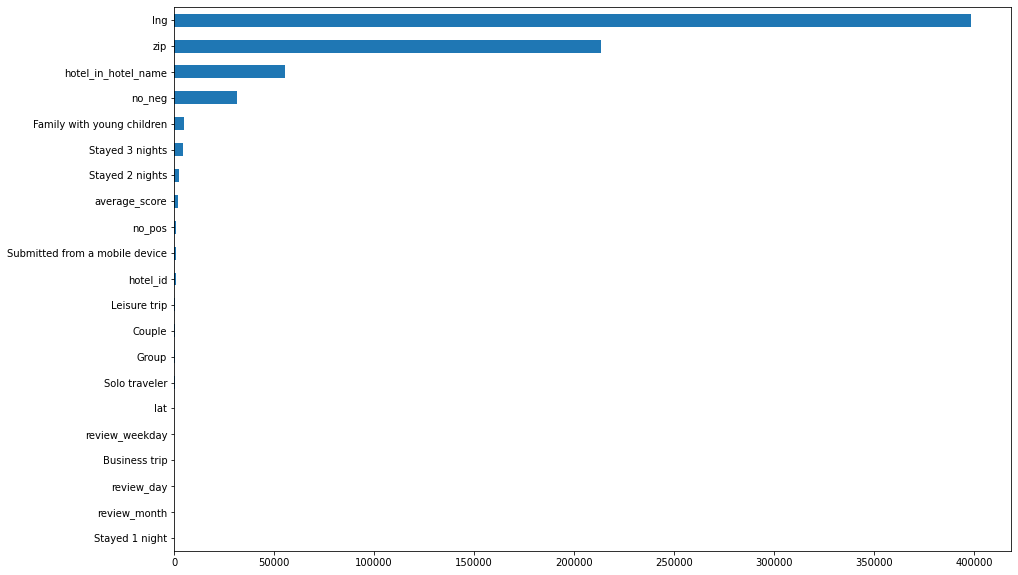

In [25]:
from sklearn.feature_selection import chi2 # хи-квадрат

# Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат.
# Выведем значения хи-квадрат на графике:

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[cat_cols]

X['lng_'] = X['lng'] - X['lng'].min()
X = X.drop(['lng'], axis=1)

plt.rcParams['figure.figsize'] = (15,10)
imp_cat = pd.Series(chi2(X, y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot:>

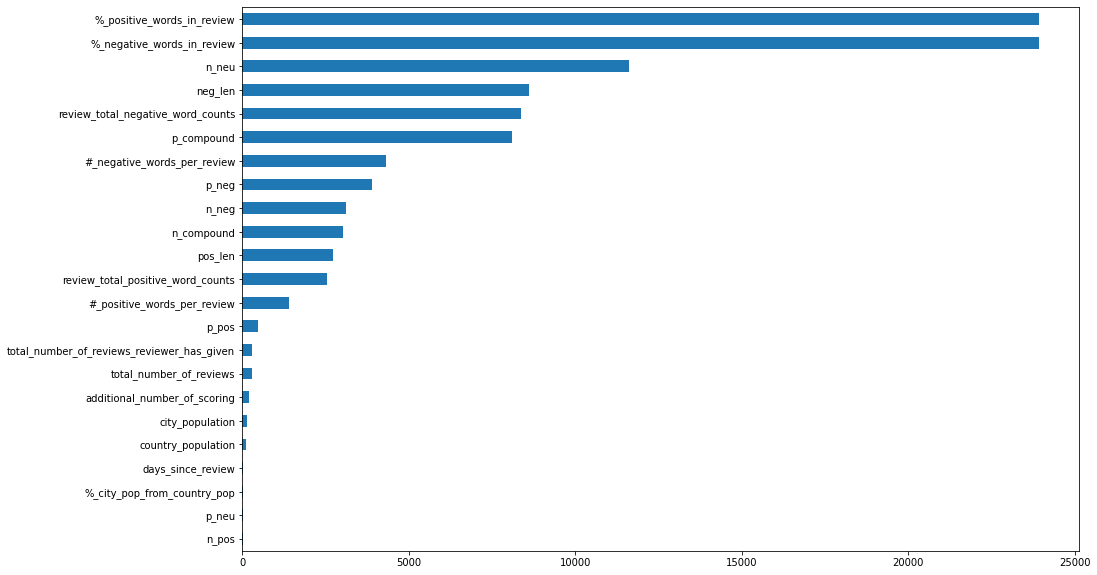

In [26]:
from sklearn.feature_selection import f_classif # anova
# Для оценки значимости непрерывных переменных будем использовать функцию f_classif из библиотеки sklearn.
# В основе метода оценки значимости переменных лежит анализ (ANOVA).
# В качестве меры значимости будем использовать значение f-статистики - чем значение статистики выше, тем меньше 
# вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей модели.

y = data.query('sample == 1').drop(['sample'], axis=1).reviewer_score.values.astype('int')
X = data.query('sample == 1').drop(['sample'], axis=1)[num_cols]

imp_num = pd.Series(f_classif(X, y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [27]:
# чтобы исключить мультиколлениарность удалим признаки, сильно коррелирующий с другим признаком
pivot = data.corr()
pivot = pivot.drop('sample', axis=0)
pivot = pivot.drop('sample', axis=1)
for col in pivot:
    pivot[col] = pivot[col].apply(lambda x: np.nan if (abs(x) < 0.2 or x == 1) else x)
for col in pivot:
    pivot = pivot.dropna(how='all')
    pivot = pivot.dropna(how='all', axis='columns')
fig = px.imshow(pivot)
fig.show()

# постараемся удалить как можно меньше признаков. Сначала удаляем признаки с максимальной корреляцией
counter = 0
for lower_bound in np.linspace(0.98, 0.72, num=14):
    for col in pivot:
        if pivot[col].max() > lower_bound or pivot[col].min() < -lower_bound:
            pivot = pivot.drop(col, axis=0)
            pivot = pivot.drop(col, axis=1)
            data = data.drop(col, axis=1)
            counter += 1
print('Deleted', counter, 'columns')

Deleted 13 columns


## <center> 4. Подготовка данных к моделированию и обучение модели ML.

In [28]:
# выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [29]:
# выделим из тренировочного датасета валидационную выборку: 80% оставим тренировочной, 20% на валидацию
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [30]:
# проверяем размерности получившихся датасетов
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 43), (386803, 43), (386803, 42), (309442, 42), (77361, 42))

In [31]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [32]:
# Обучаем модель
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.7s finished


**определяем метрики модели ML**

In [33]:
# Пишем свою функцию Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [34]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAE: 0.8661408590892048
MAPE: 12.324122729876366


<AxesSubplot:>

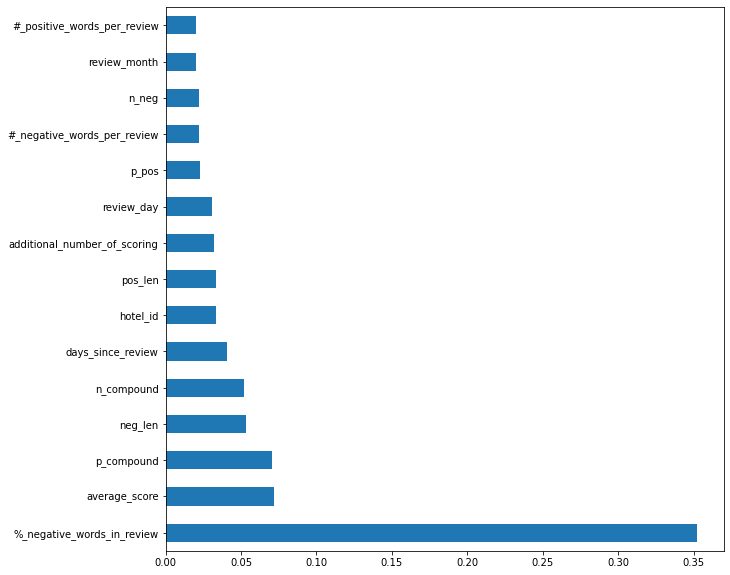

In [35]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [36]:
test_data = test_data.drop(['reviewer_score'], axis=1)

## <center> 5. Сохрание  submission для участия в соревновании Kaagle.com.

In [37]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.7s finished


In [38]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission_PP.csv', index=False)
sample_submission.head(10)

reviewer_score      id
0           8.639  488440
1           7.062  274649
2           8.160  374688
3           9.637  404352
4           9.425  451596
5           8.943  302161
6           7.536  317079
7           7.455   13963
8           8.685  159785
9           7.435  195089